<a href="https://colab.research.google.com/github/Devi7uke/SearchAlgorithms/blob/main/Proyecto_IA_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> # Proyecto de Inteligencia Artificial II

## Integrantes:
* Montalvo Rodríguez Ángel Silvestre
* Castro Guzmán Arturo Alejandro
* Frias Sandoval Brayan Javier
<br/><br/><br/>

  <img src="https://static-00.iconduck.com/assets.00/tensorflow-icon-955x1024-hd4xzbqj.png" alt="TF" width="300"/>

<br/><br/>

#### El proyecto tiene como objetivo calcular, con una semana de anticipación, el valor de una acción cotizada en la Bolsa Mexicana de Valores. La acción de Walmart México ha sido elegida como objetivo principal para el modelo predictivo. En el desarrollo de este proyecto, se ha empleado la biblioteca TensorFlow Keras, se han obtenido datos de Yahoo Finance y se han aplicado técnicas como la validación cruzada para la construcción del modelo.


> ## Importación de las bibliotecas

In [305]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sb

In [306]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, Activation
from keras.callbacks import ModelCheckpoint

In [307]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold

> ## Selección de los datos

In [308]:
oFile = pd.read_csv('PWDATASDELAYED.csv')
oFile['Date'] = pd.to_datetime(oFile['Date'], format='%d/%m/%Y')

In [309]:
cutoff = '2023-11-6'
data = oFile[oFile['Date'].between('2015-01-05', cutoff)]
data = data.drop(columns=['Date', 'DateUndelayed', 'Open(WALMEX.MX)'])
data

,Close(SORIANAB.MX),Close(CHDRAUIB.MX),Close(WMT),Close(LIVEPOLC-1.MX),Close(AMZN.MX),Close(BIMBOA.MX),Close(KO),Close(PG),Close(SS),Close(KS),Close(CLX),Close(^MXX),Close(WALMEX.MX)
0,38.799999,41.230000,89.349998,145.910004,216.600006,40.220001,43.029999,90.250000,11.840000,26280,106.620003,40984.21875,29.410000
1,36.060001,41.330002,86.769997,142.750000,210.875000,39.160000,42.529999,91.250000,12.590000,26320,109.080002,42488.73047,30.040001
2,36.000000,41.639999,88.510002,151.179993,230.000000,40.410000,43.310001,90.080002,12.220000,27720,108.400002,42158.07031,28.950001
3,34.939999,41.540001,84.980003,153.570007,266.575012,38.139999,41.169998,84.290001,14.190000,27300,106.709999,41710.82031,32.180000
4,35.810001,43.299999,87.330002,155.979996,277.899994,39.330002,41.450001,85.610001,14.720000,27440,106.930000,41933.26172,32.970001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,29.850000,104.370003,159.830002,87.980003,2341.919922,78.220001,52.889999,144.690002,22.549999,68000,122.449997,49274.78125,59.580002
458,29.049999,101.540001,158.759995,88.720001,2286.560059,73.389999,54.570000,148.050003,22.030001,68800,122.800003,48766.32813,66.589996
459,31.000000,105.260002,161.169998,89.940002,2309.270020,72.620003,55.240002,147.160004,22.650000,67300,117.930000,49787.83984,66.820000
460,32.450001,99.610001,164.660004,92.000000,2419.340088,78.669998,56.740002,150.070007,23.549999,69600,125.550003,51016.30078,67.129997


In [310]:
corr = data.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm', axis=None)

,Close(SORIANAB.MX),Close(CHDRAUIB.MX),Close(WMT),Close(LIVEPOLC-1.MX),Close(AMZN.MX),Close(BIMBOA.MX),Close(KO),Close(PG),Close(SS),Close(KS),Close(CLX),Close(^MXX),Close(WALMEX.MX)
Close(SORIANAB.MX),1.000000,0.150264,-0.756717,0.834186,-0.837210,0.042351,-0.565394,-0.703904,0.466305,-0.655276,-0.767854,0.234002,-0.656460
Close(CHDRAUIB.MX),0.150264,1.000000,0.342041,0.074780,-0.067986,0.912626,0.470304,0.353325,0.494868,0.156089,-0.245691,0.589404,0.395479
Close(WMT),-0.756717,0.342041,1.000000,-0.826330,0.852788,0.486347,0.849711,0.949278,-0.174156,0.880987,0.643690,0.300093,0.880203
Close(LIVEPOLC-1.MX),0.834186,0.074780,-0.826330,1.000000,-0.873826,-0.066997,-0.590287,-0.747855,0.403413,-0.812798,-0.778679,0.037599,-0.672846
Close(AMZN.MX),-0.837210,-0.067986,0.852788,-0.873826,1.000000,0.143246,0.635472,0.810053,-0.389605,0.870284,0.816323,0.096444,0.783799
Close(BIMBOA.MX),0.042351,0.912626,0.486347,-0.066997,0.143246,1.000000,0.641879,0.555887,0.383224,0.338584,-0.079957,0.668322,0.577104
Close(KO),-0.565394,0.470304,0.849711,-0.590287,0.635472,0.641879,1.000000,0.908654,-0.184798,0.745774,0.380667,0.483759,0.902302
Close(PG),-0.703904,0.353325,0.949278,-0.747855,0.810053,0.555887,0.908654,1.000000,-0.145698,0.840734,0.595188,0.342988,0.891266
Close(SS),0.466305,0.494868,-0.174156,0.403413,-0.389605,0.383224,-0.184798,-0.145698,1.000000,-0.228639,-0.414411,0.275487,-0.254862
Close(KS),-0.655276,0.156089,0.880987,-0.812798,0.870284,0.338584,0.745774,0.840734,-0.228639,1.000000,0.630259,0.436410,0.817448


In [311]:
data[['Close(KS)', 'Close(BIMBOA.MX)', 'Close(WALMEX.MX)']].corr(method='pearson').style.background_gradient(cmap='coolwarm', axis=None)

,Close(KS),Close(BIMBOA.MX),Close(WALMEX.MX)
Close(KS),1.000000,0.338584,0.817448
Close(BIMBOA.MX),0.338584,1.000000,0.577104
Close(WALMEX.MX),0.817448,0.577104,1.000000


In [312]:
cols = ['Close(KS)', 'Close(BIMBOA.MX)']
dataX, dataY = data[cols],  data['Close(WALMEX.MX)']

In [313]:
scaler = StandardScaler()
scaler.fit(data)
data_est = pd.DataFrame(scaler.fit_transform(data),columns=data.columns)
data_est['Date'] = oFile['Date']

> #### Visualización del comportamiento de las variables independientes seleccionadas a través del tiempo (2015 - 2023)

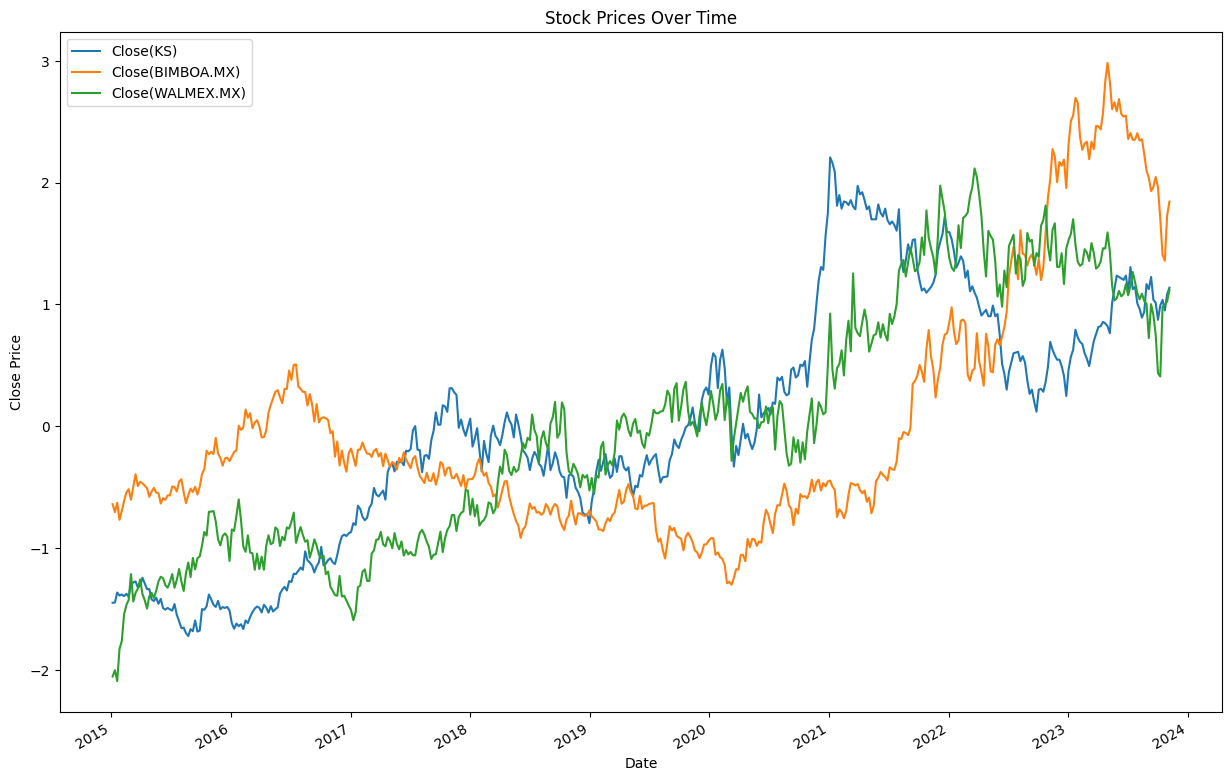

In [352]:
plt.figure(figsize=(15, 10))
for col in cols:
  plt.plot(data_est['Date'], data_est[col], label=col)

plt.plot(data_est['Date'], data_est['Close(WALMEX.MX)'], label='Close(WALMEX.MX)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Prices Over Time')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.gcf().autofmt_xdate()
plt.show()

#### Para simplificar la gestión de los datos estandarizados, se han utilizado dos objetos de estandarización, uno para las variables independientes y otro para la dependiente.

#### Para la estandarización de los datos, se hizo uso de las siguientes fórmulas implementadas por la biblioteca StandardScaler de Sklearn:

* # $\sigma = \sqrt{\frac{\sum_{i=1}^{n}(x_i - \bar{x})^2}{n}}$
* # $z_i = \frac{x_i - \mu}{\sigma}$

#### La letra griega $\sigma$ (sigma minúscula) representa la desviación estándar del conjunto de datos.

<br/>

#### La puntuación $z_i$ indica cuántas desviaciones estándar el i-ésimo elemento se encuentra por encima o por debajo de la media en un conjunto de datos distribuido de manera normal.

<br/>

<img src="https://i.imgur.com/LS4gtTZ.png" alt="gauss" width="200"/>


In [315]:
scalerX = StandardScaler()
scalerY = StandardScaler()
scalerX.fit(dataX)
scalerY.fit(np.array(dataY).reshape(-1, 1))
st_data_X = pd.DataFrame(scalerX.fit_transform(dataX),columns=dataX.columns)
st_data_Y = pd.DataFrame(scalerY.fit_transform(np.array(dataY).reshape(-1, 1)),columns=['Close(WALMEX.MX)'])

In [316]:
X_array = np.array(st_data_X)
y_array = np.array(st_data_Y)

> # TensorFlow

### Para obtener resultados que sean reporducibles, hemos establecido la semilla de TensorFlow y K-Fold en 42.

In [317]:
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#### A través de varios intentos, identificamos que la función de activación que produce los mejores resultados es la Leaky ReLU. Esta función ha demostró permitir una convergencia rápida con puntuaciones muy buenas en nuestras evaluaciones.

* ## $ f(x) = \max(0.1x, x) $

In [353]:
def newModel():
  tf.keras.backend.clear_session()
  model = tf.keras.Sequential()
  model.add(Dense(units=500, input_dim=dataX.shape[1]))
  model.add(LeakyReLU(alpha=0.01))
  model.add(Dense(units=250))
  model.add(LeakyReLU(alpha=0.01))
  model.add(Dense(units=100))
  model.add(LeakyReLU(alpha=0.01))
  model.add(Dense(1, activation='linear'))
  return model

> ## Validación cruzada

Utilizamos la técnica de validación cruzada para evaluar y determinar el mejor conjunto de datos. En particular, empleamos la herramienta k-fold, dividiendo nuestro conjunto de datos en k subconjuntos. Luego, realizamos k iteraciones, utilizando un subconjunto como conjunto de prueba en cada iteración y los k-1 subconjunto restantes como conjunto de entrenamiento.

<img src="https://www.researchgate.net/publication/317636497/figure/fig1/AS:506164930908160@1497690531620/Figura-No-1-Ejemplo-de-validacion-cruzada-para-5-folds-Clasificacion-Para-la-induccion.png" alt="gauss" width="300"/>

Finalmente, extraímos los índices del mejor conjunto de datos utilizando el error cuadrático medio. Esta métrica nos permitió identificar de manera precisa el conjunto de datos que proporcionó el mejor rendimiento en términos de ajuste al modelo.

* ## $\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$


3/3 [==============================] - 0s 6ms/step
Mean Square Error: 0.05058139404160047
3/3 [==============================] - 0s 5ms/step
Mean Square Error: 0.034337802949204785
3/3 [==============================] - 0s 6ms/step
Mean Square Error: 0.04013331946616928
3/3 [==============================] - 0s 6ms/step
Mean Square Error: 0.03901078345627622
3/3 [==============================] - 0s 5ms/step
Mean Square Error: 0.03171512213260634






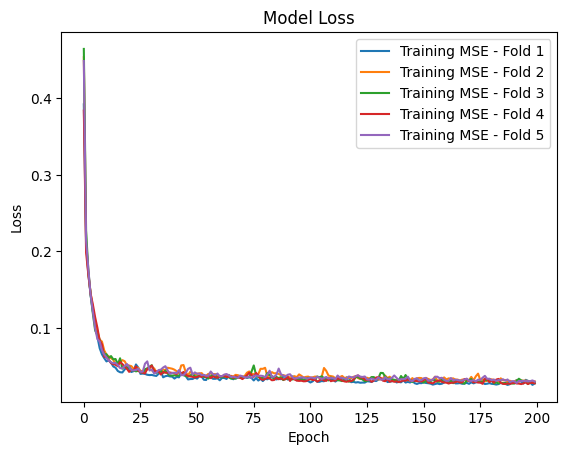

In [319]:
best = float("inf")
best_fold = None
for fold_index, (train_index, test_index) in enumerate(kf.split(X_array, y_array)):
    X_train, X_test = X_array[train_index], X_array[test_index]
    y_train, y_test = y_array[train_index], y_array[test_index]
    net = newModel()
    net.compile(loss='mean_squared_error', optimizer = 'adam')
    history = net.fit(X_train, y_train, epochs=200, verbose=0)
    plt.plot(history.history['loss'], label=f'Training MSE - Fold {fold_index + 1}')
    pred = net.predict(X_test)
    MSE = mean_squared_error(y_test, pred)
    print(f'Mean Square Error: {MSE}')
    if best > MSE :
      best = MSE
      best_fold = (train_index, test_index)
print("\n\n\n")
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

> ## Realizamos la extracción del mejor modelo basándonos en los datos que arrojaron los mejores resultados.

In [320]:
train_index, test_index = best_fold
X_train, X_test = X_array[train_index], X_array[test_index]
y_train, y_test = y_array[train_index], y_array[test_index]

In [321]:
net = newModel()
net.compile(loss='mean_squared_error', optimizer = 'adam')
net.fit(X_train, y_train, epochs=1000, verbose=0)

In [322]:
pred = net.predict(X_test)

3/3 [==============================] - 0s 4ms/step


In [323]:
mean_squared_error(y_test, pred)

0.03950716829861039

> ## Desestandarización

Para presentar las predicciones de manera comprensible, llevamos a cabo el proceso de desestandarización de los datos. Este procedimiento revierte la estandarización previamente aplicada, devolviendo las predicciones a la escala original de los datos.

In [324]:
data_or_X = X_array[test_index]
data_or_X = pd.DataFrame(data_or_X, columns=dataX.columns)
data_or_X = scalerX.inverse_transform(data_or_X)
data_or_X = pd.DataFrame(data_or_X, columns=dataX.columns)

In [325]:
data_or_Y = y_array[test_index]
data_or_Y = pd.DataFrame(data_or_Y, columns=['Close(WALMEX.MX)'])
data_or_Y = scalerY.inverse_transform(np.array(data_or_Y).reshape(-1, 1))
data_or_Y = pd.DataFrame(data_or_Y, columns=['Close(WALMEX.MX)'])

In [326]:
res = pd.concat([data_or_X, data_or_Y], axis=1)
res

,Close(KS),Close(BIMBOA.MX),Close(WALMEX.MX)
0,26320.0,39.160000,30.040001
1,29800.0,43.000000,37.709999
2,26140.0,41.680000,38.990002
3,26820.0,40.310001,39.439999
4,22580.0,42.299999,39.410000
...,...,...,...
87,70600.0,88.750000,69.070000
88,71000.0,84.620003,66.889999
89,68800.0,82.440002,65.779999
90,68800.0,73.389999,66.589996


# Pruebas
Ampliamos el conjunto de datos del modelo de predicción incorporando nuevos datos a nuestras variables independientes. Al incluir estos datos actualizados, buscamos evaluar y visualizar la fiabilidad de nuestro modelo.

In [327]:
from datetime import datetime, timedelta

In [328]:
current_date = pd.to_datetime(datetime.now().date() + timedelta(weeks=1))
data_new = oFile[oFile['Date'].between(cutoff, current_date)]
data_new

,Date,Close(SORIANAB.MX),Close(CHDRAUIB.MX),Close(WMT),Close(LIVEPOLC-1.MX),Close(AMZN.MX),Close(BIMBOA.MX),Close(KO),Close(PG),Close(SS),Close(KS),Close(CLX),Close(^MXX),DateUndelayed,Open(WALMEX.MX),Close(WALMEX.MX)
461,2023-11-06,29.980000,100.360001,166.190002,92.339996,2530.510010,80.500000,56.720001,151.410004,23.920000,70500,133.460007,52796.46875,13/11/2023,66.559998,68.300003
462,2023-11-13,30.490000,100.379997,155.350006,94.779999,2495.550049,83.440002,57.259998,151.070007,24.020000,72500,139.169998,52670.01172,20/11/2023,68.500000,69.620003
463,2023-11-20,30.299999,101.529999,156.059998,96.839996,2527.010010,85.879997,58.570000,151.380005,23.969999,71700,141.190002,52938.42188,27/11/2023,69.620003,69.339996
464,2023-11-27,30.299999,101.650002,156.059998,96.839996,2527.010010,85.510002,58.570000,151.380005,23.969999,71700,141.190002,52938.42188,04/11/2023,NaN,NaN


In [342]:
X_new = np.array(data_new[cols])
X_new_st = scalerX.fit_transform(X_new)

In [343]:
pred = net.predict(X_new_st)
stock_forecast = scalerY.inverse_transform(pred)
stock_forecast

1/1 [==============================] - 0s 147ms/step


array([[35.557602],
       [67.92653 ],
       [66.45741 ],
       [61.715183]], dtype=float32)

In [349]:
data_new_or = X_new_st
data_new_or = pd.DataFrame(data_new_or, columns=dataX.columns)
data_new_or = scalerX.inverse_transform(data_new_or)
data_new_or = pd.DataFrame(data_new_or, columns=dataX.columns)

data_new_or['Close(WALMEX.MX)'] = stock_forecast

data_new_or['DDate'] = np.array(data_new['Date'])
data_new_or['Date'] = ['2023-11-10', '2023-11-17', '2023-11-24', '2023-12-01']
data_new_or[['DDate', 'Close(KS)', 'Close(BIMBOA.MX)', 'Date', 'Close(WALMEX.MX)']]

,DDate,Close(KS),Close(BIMBOA.MX),Date,Close(WALMEX.MX)
0,2023-11-06,70500.0,80.500000,2023-11-10,35.557602
1,2023-11-13,72500.0,83.440002,2023-11-17,67.926529
2,2023-11-20,71700.0,85.879997,2023-11-24,66.457413
3,2023-11-27,71700.0,85.510002,2023-12-01,61.715183


> ## Conclusiones

* #### Ángel SMR:
* #### Arturo ACG:
* #### Brayan JFS:
